In [46]:
#libraries
library(pracma)
library(ggplot2)
library(maps) 
library(patchwork)
library(plyr)
library(dplyr)
library(ggnewscale)
library(ggpubr)

In [47]:
rm(list = ls())

setwd("/home/yow004/Documents/GitHub/NonergodicSD")

#user functions
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')

In [48]:
#input file
flatfile_fname <- 'data/compile_all.csv'
reg_name <- 'SD_regression_ds1_inla'
res_name<-'tot_0'
df_flatfile <- read.csv(flatfile_fname)

  #UTM zone
  utm_zone <- unique(df_flatfile$UTMzone)
  utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))

In [49]:
#event index
event<-df_flatfile %>% group_by(eqid) %>% filter(row_number()==1)

#station index
station<-df_flatfile %>% group_by(Site) %>% filter(row_number()==1)

Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”


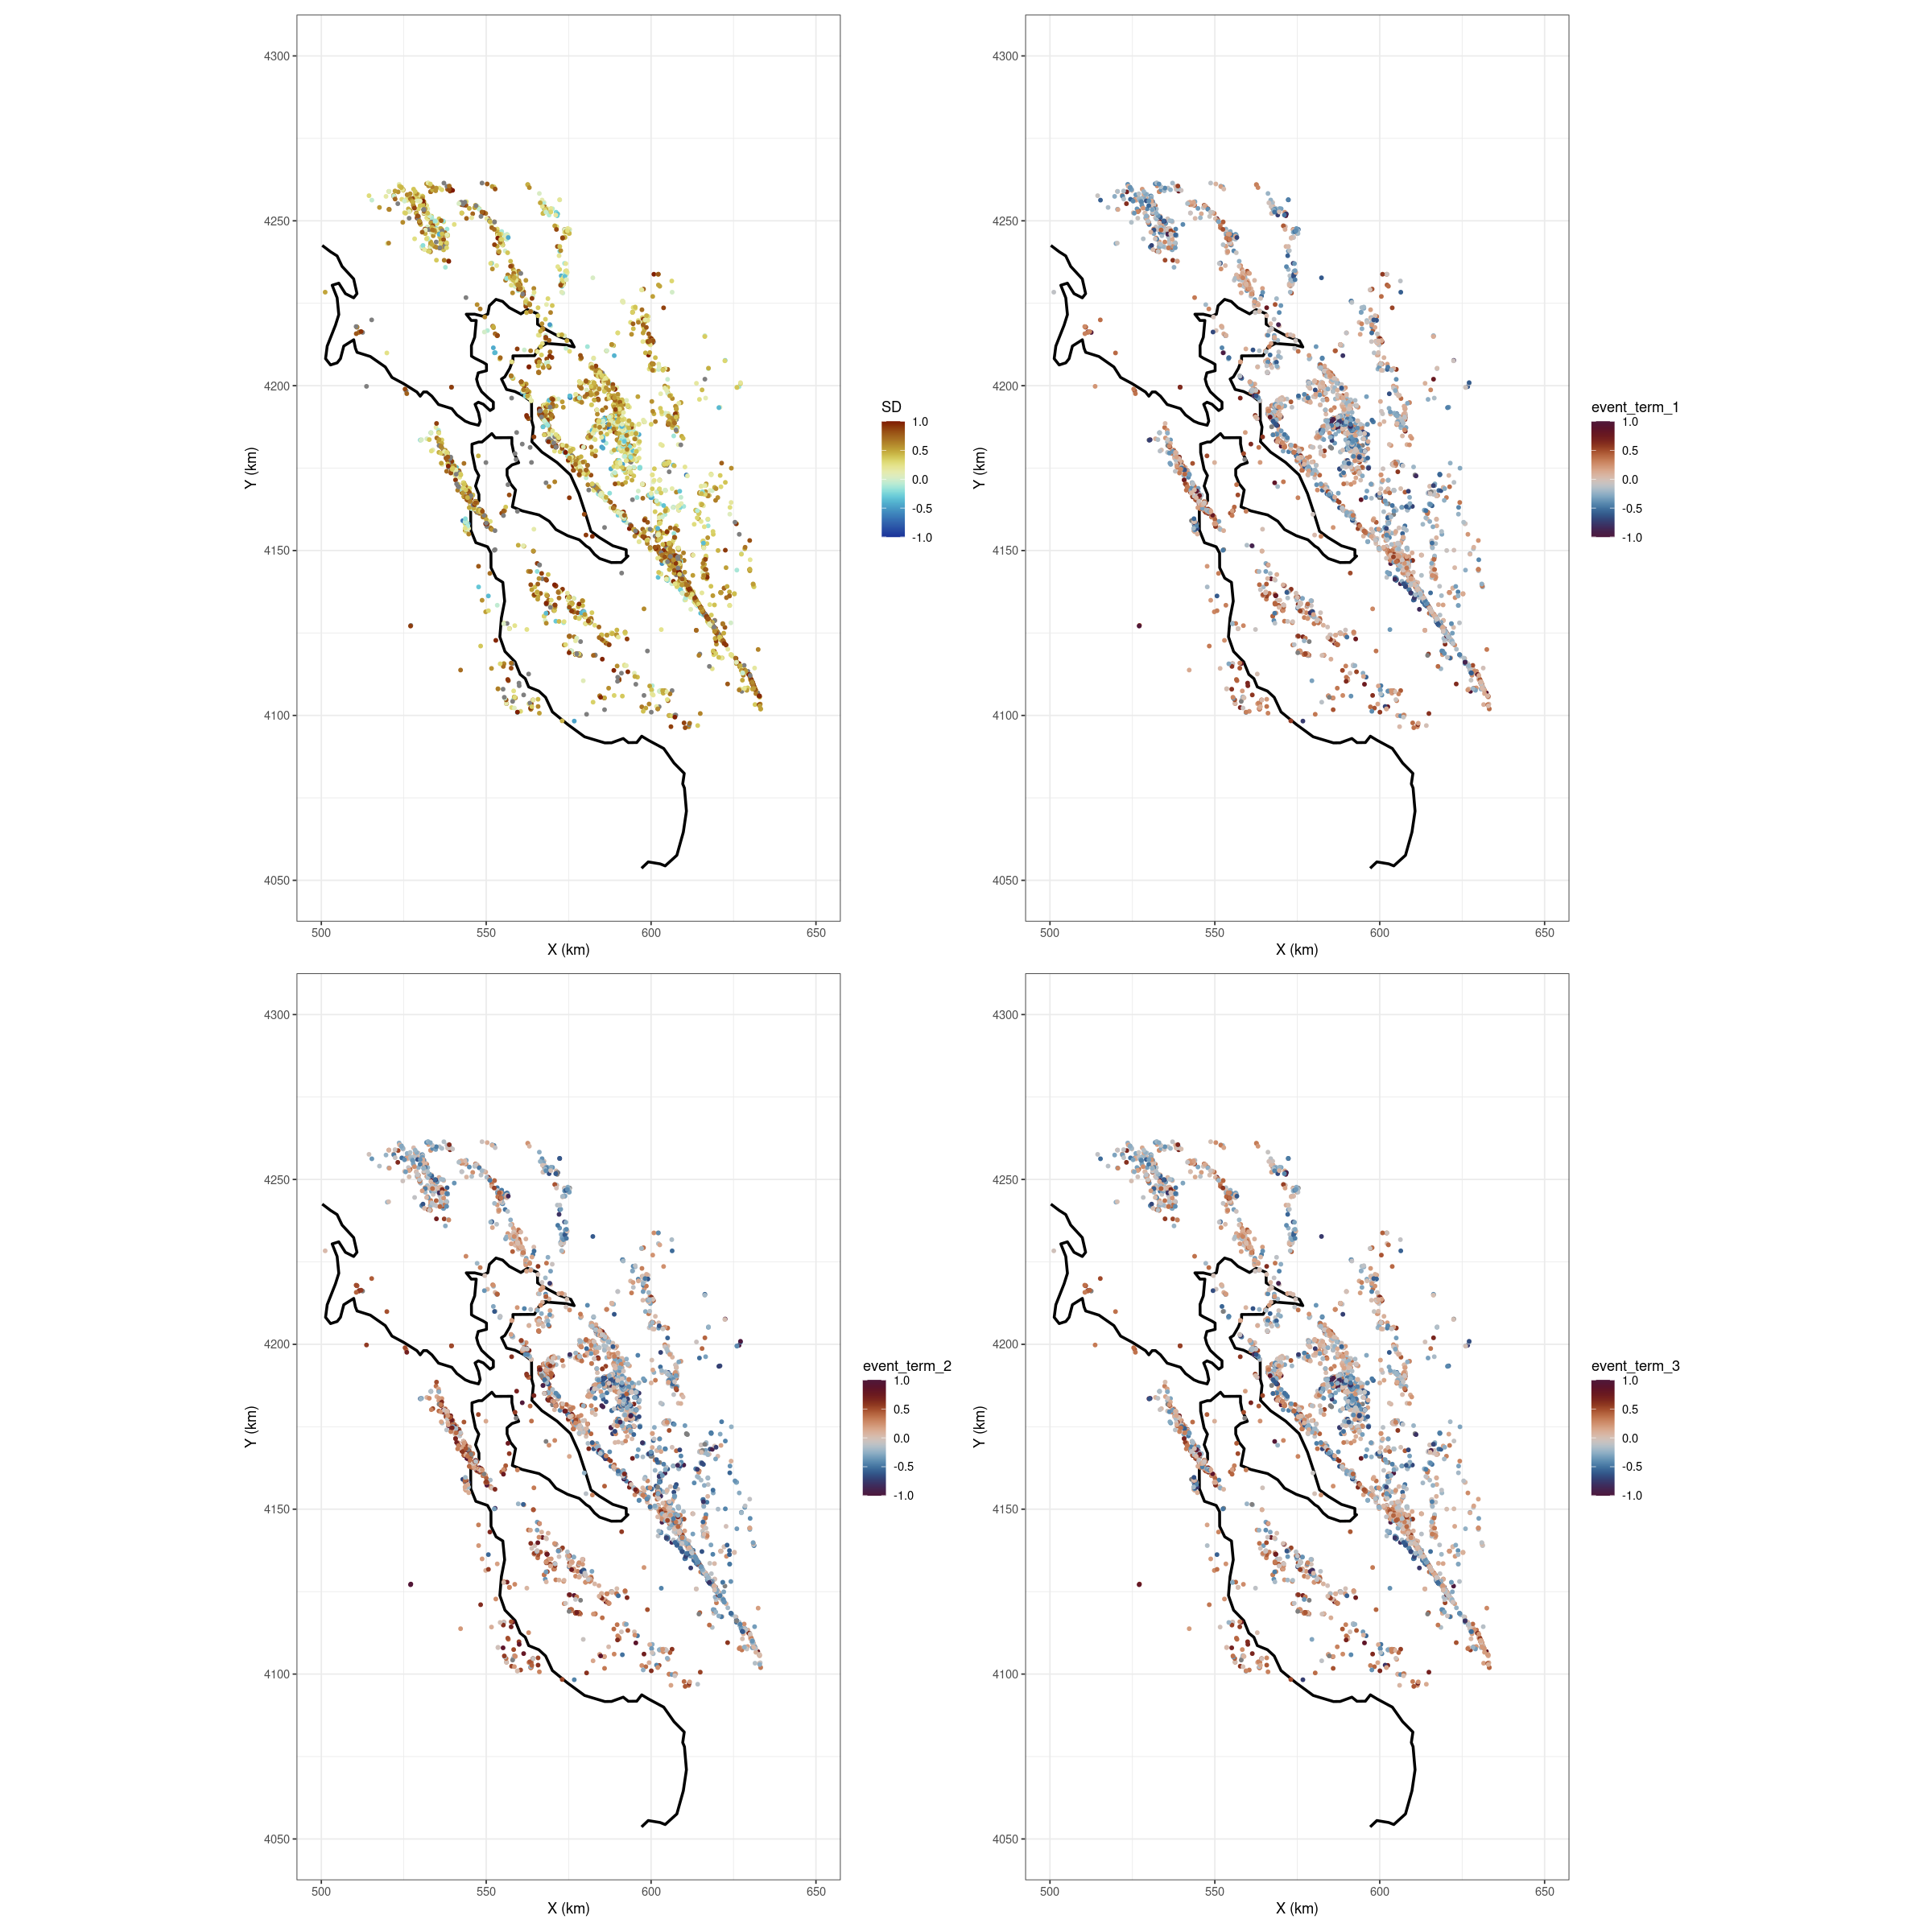

In [50]:
options(repr.plot.width=20, repr.plot.height=20)

#California
map_ca <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000

#Earthquake - Station Mesh
  pl_mesh  <- ggplot() + theme_bw() + 
              geom_path(data=map_ca, aes(x=X,y=Y), color='black',size=1) +
              #geom_point(data=df_flatfile, aes(x=eqX,y=eqY),size=0.5,color='red') +
              labs(x="X (km)", y="Y (km)") + coord_fixed(ratio = 1) + 
              xlim(500,650) + ylim(4050,4300) 
#geom_point(data=station, aes(x=staX,y=staY,color=Vs30),size=5,shape=17)+scico::scale_colour_scico(palette = 'acton') + new_scale_color()
              

cmap<-"vikO"
zlim<-c(-1,1)
dic<- 1

p1 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=SD),size=1) +scico::scale_colour_scico(palette = "roma",limits=c(-1,1),direction=-1)
p2 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=event_term_1),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)
p3 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=event_term_2),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)
p4 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=event_term_3),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)


p1+p2 + p3+p4+ plot_layout(ncol = 2)



In [51]:
colnames(df_flatfile)[which(names(df_flatfile) == "eqlat")] <- "eqLat"
colnames(df_flatfile)[which(names(df_flatfile) == "eqlon")] <- "eqLon"
colnames(df_flatfile)[which(names(df_flatfile) == "stalat")] <- "staLat"
colnames(df_flatfile)[which(names(df_flatfile) == "stalon")] <- "staLon"

  # Preprocess Input Data
  # ---------------------------
  n_data <- nrow(df_flatfile)
  #earthquake data
  data_eq_all <- df_flatfile[,c('eqid','mag','eqX', 'eqY')]
  out_unq  <- UniqueIdxInv(df_flatfile[,'eqid'])
  eq_idx   <- out_unq$idx
  eq_inv   <- out_unq$inv
  data_eq  <- data_eq_all[eq_idx,]
  X_eq     <- data_eq[,c(3,4)] #earthquake coordinates
  X_eq_all <- data_eq_all[,c(3,4)]
  #create earthquake ids for all records (1 to n_eq)
  eq_id <- eq_inv
  n_eq  <- nrow(data_eq)
  
  #station data
  data_sta_all <- df_flatfile[,c('ssn','Vs30','staX','staY')]
  out_unq   <- UniqueIdxInv(df_flatfile[,'ssn'])
  sta_idx   <- out_unq$idx
  sta_inv   <- out_unq$inv
  data_sta  <- data_sta_all[sta_idx,]
  X_sta     <- data_sta[,c(3,4)] #station coordinates
  X_sta_all <- data_sta_all[,c(3,4)]
  #create station indices for all records (1 to n_sta)
  sta_id <- sta_inv
  n_sta  <- nrow(data_sta)
  
  #ground-motion observations  
  y_data <- df_flatfile[,res_name]
  
  #UTM zone
  utm_zone <- unique(df_flatfile$UTMzone)
  utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))

df_flatfile[,'rsn'] <- 1:n_data

In [52]:
# PGA regression
dir_out <- 'data/SD_3_ds1_inla/'

#load non-ergodic coefficients and residuals
fname_gmotion <- file.path(dir_out, paste0(reg_name,'_inla_residuals.csv'))
fname_coeff   <- file.path(dir_out, paste0(reg_name,'_inla_coefficients.csv'))
df_gmotion_PGA <- read.csv(fname_gmotion)
df_coeff_PGA   <- read.csv(fname_coeff)


dir_out <- 'data/SD_SD_ds1_inla/'

#load non-ergodic coefficients and residuals
fname_gmotion <- file.path(dir_out, paste0(reg_name,'_inla_residuals.csv'))
fname_coeff   <- file.path(dir_out, paste0(reg_name,'_inla_coefficients.csv'))
df_gmotion_SD <- read.csv(fname_gmotion)
df_coeff_SD   <- read.csv(fname_coeff)




In [61]:
event_term<-df_coeff_PGA$dc_1e_mean
SD_term<-df_coeff_SD$dc_1e_mean
SD<-df_flatfile$SD*log(10)
eqX<-df_coeff_PGA$eqX
eqY<-df_coeff_PGA$eqY

In [62]:
comp<-data.frame(eqX,eqY,event_term,SD_term,SD)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.




	Pearson's product-moment correlation

data:  comp$event_term and comp$SD_term
t = 523.14, df = 180951, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7740324 0.7777002
sample estimates:
      cor 
0.7758729 



	Pearson's product-moment correlation

data:  comp$event_term and comp$SD
t = 263.15, df = 180951, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5227462 0.5294108
sample estimates:
      cor 
0.5260866 


Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”


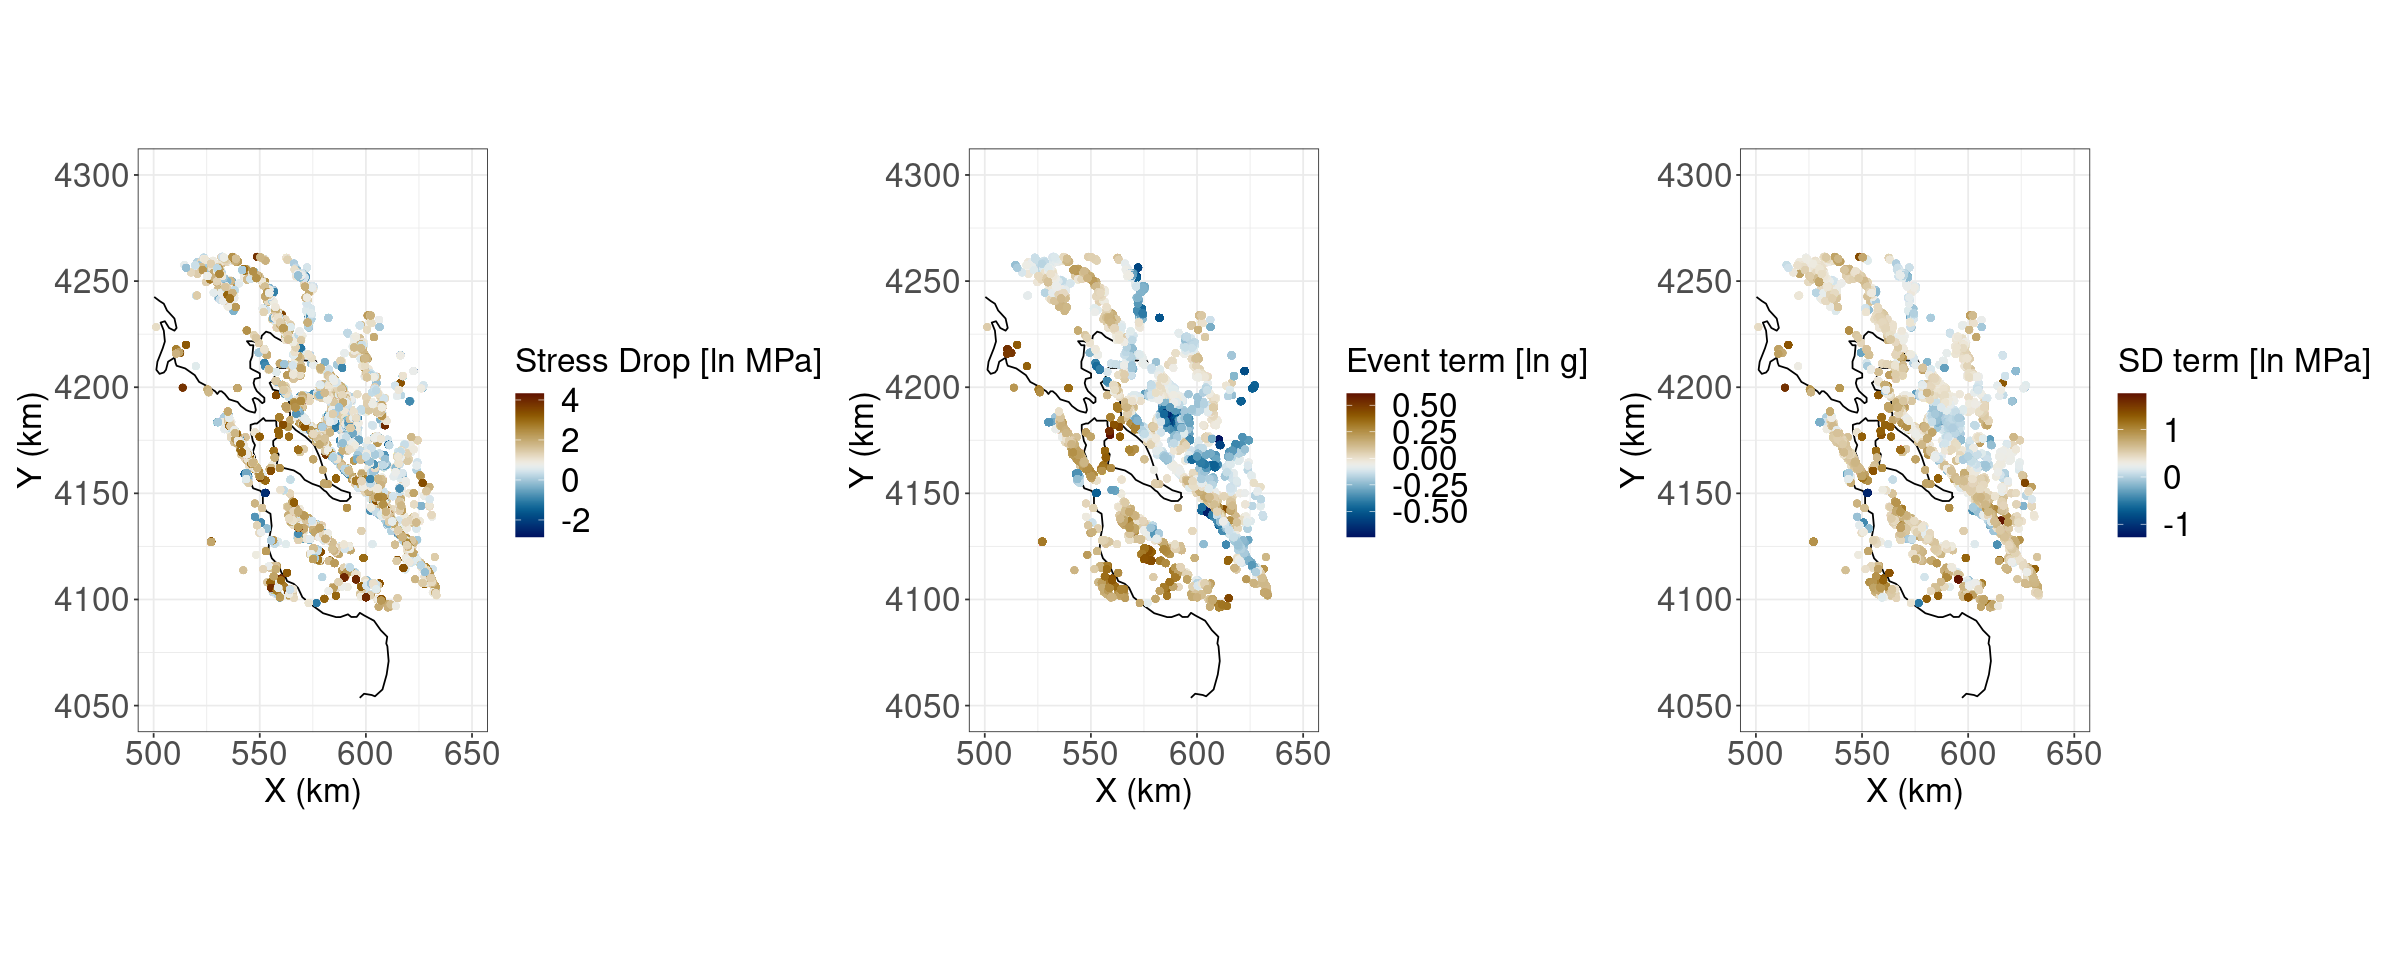

In [75]:
options(repr.plot.width=20, repr.plot.height=8)
#UTM zone
utm_zone <- unique(df_flatfile$UTMzone)
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))
#California
map_ca     <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv     <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000

#base map
pl_map <- ggplot() + theme_bw() + coord_fixed(ratio = 1) + xlim(500,650) + ylim(4050,4300) +
            geom_path(data=map_ca, aes(x=X,y=Y), color='black') + coord_fixed(ratio = 1)

#spatially varying earthquake adjustment
p0 <- pl_map + geom_point(data=comp, aes(eqX, eqY, color=SD)) +
                      scico::scale_color_scico(palette = "vik")+
                      labs(x='X (km)', y='Y (km)', color='Stress Drop [ln MPa]') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

p1 <- pl_map + geom_point(data=comp, aes(eqX, eqY, color=event_term)) +
                      scico::scale_color_scico(palette = "vik")+
                      labs(x='X (km)', y='Y (km)', color='Event term [ln g]') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

p2 <- pl_map + geom_point(data=comp, aes(eqX, eqY, color=SD_term)) +
                      scico::scale_color_scico(palette = "vik")+
                      labs(x='X (km)', y='Y (km)', color='SD term [ln MPa]') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))


res <- cor.test(comp$event_term, comp$SD_term, method = "pearson")
res
p3<-ggscatter(comp, x = "event_term", y = "SD_term", 
              add = "reg.line", add.params = list(color = "red"),conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop term")

res <- cor.test(comp$event_term, comp$SD, method = "pearson")
res
p4<-ggscatter(comp, x = "event_term", y = "SD", 
              add = "reg.line", add.params = list(color = "red"),conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop")


p0+p1+p2

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



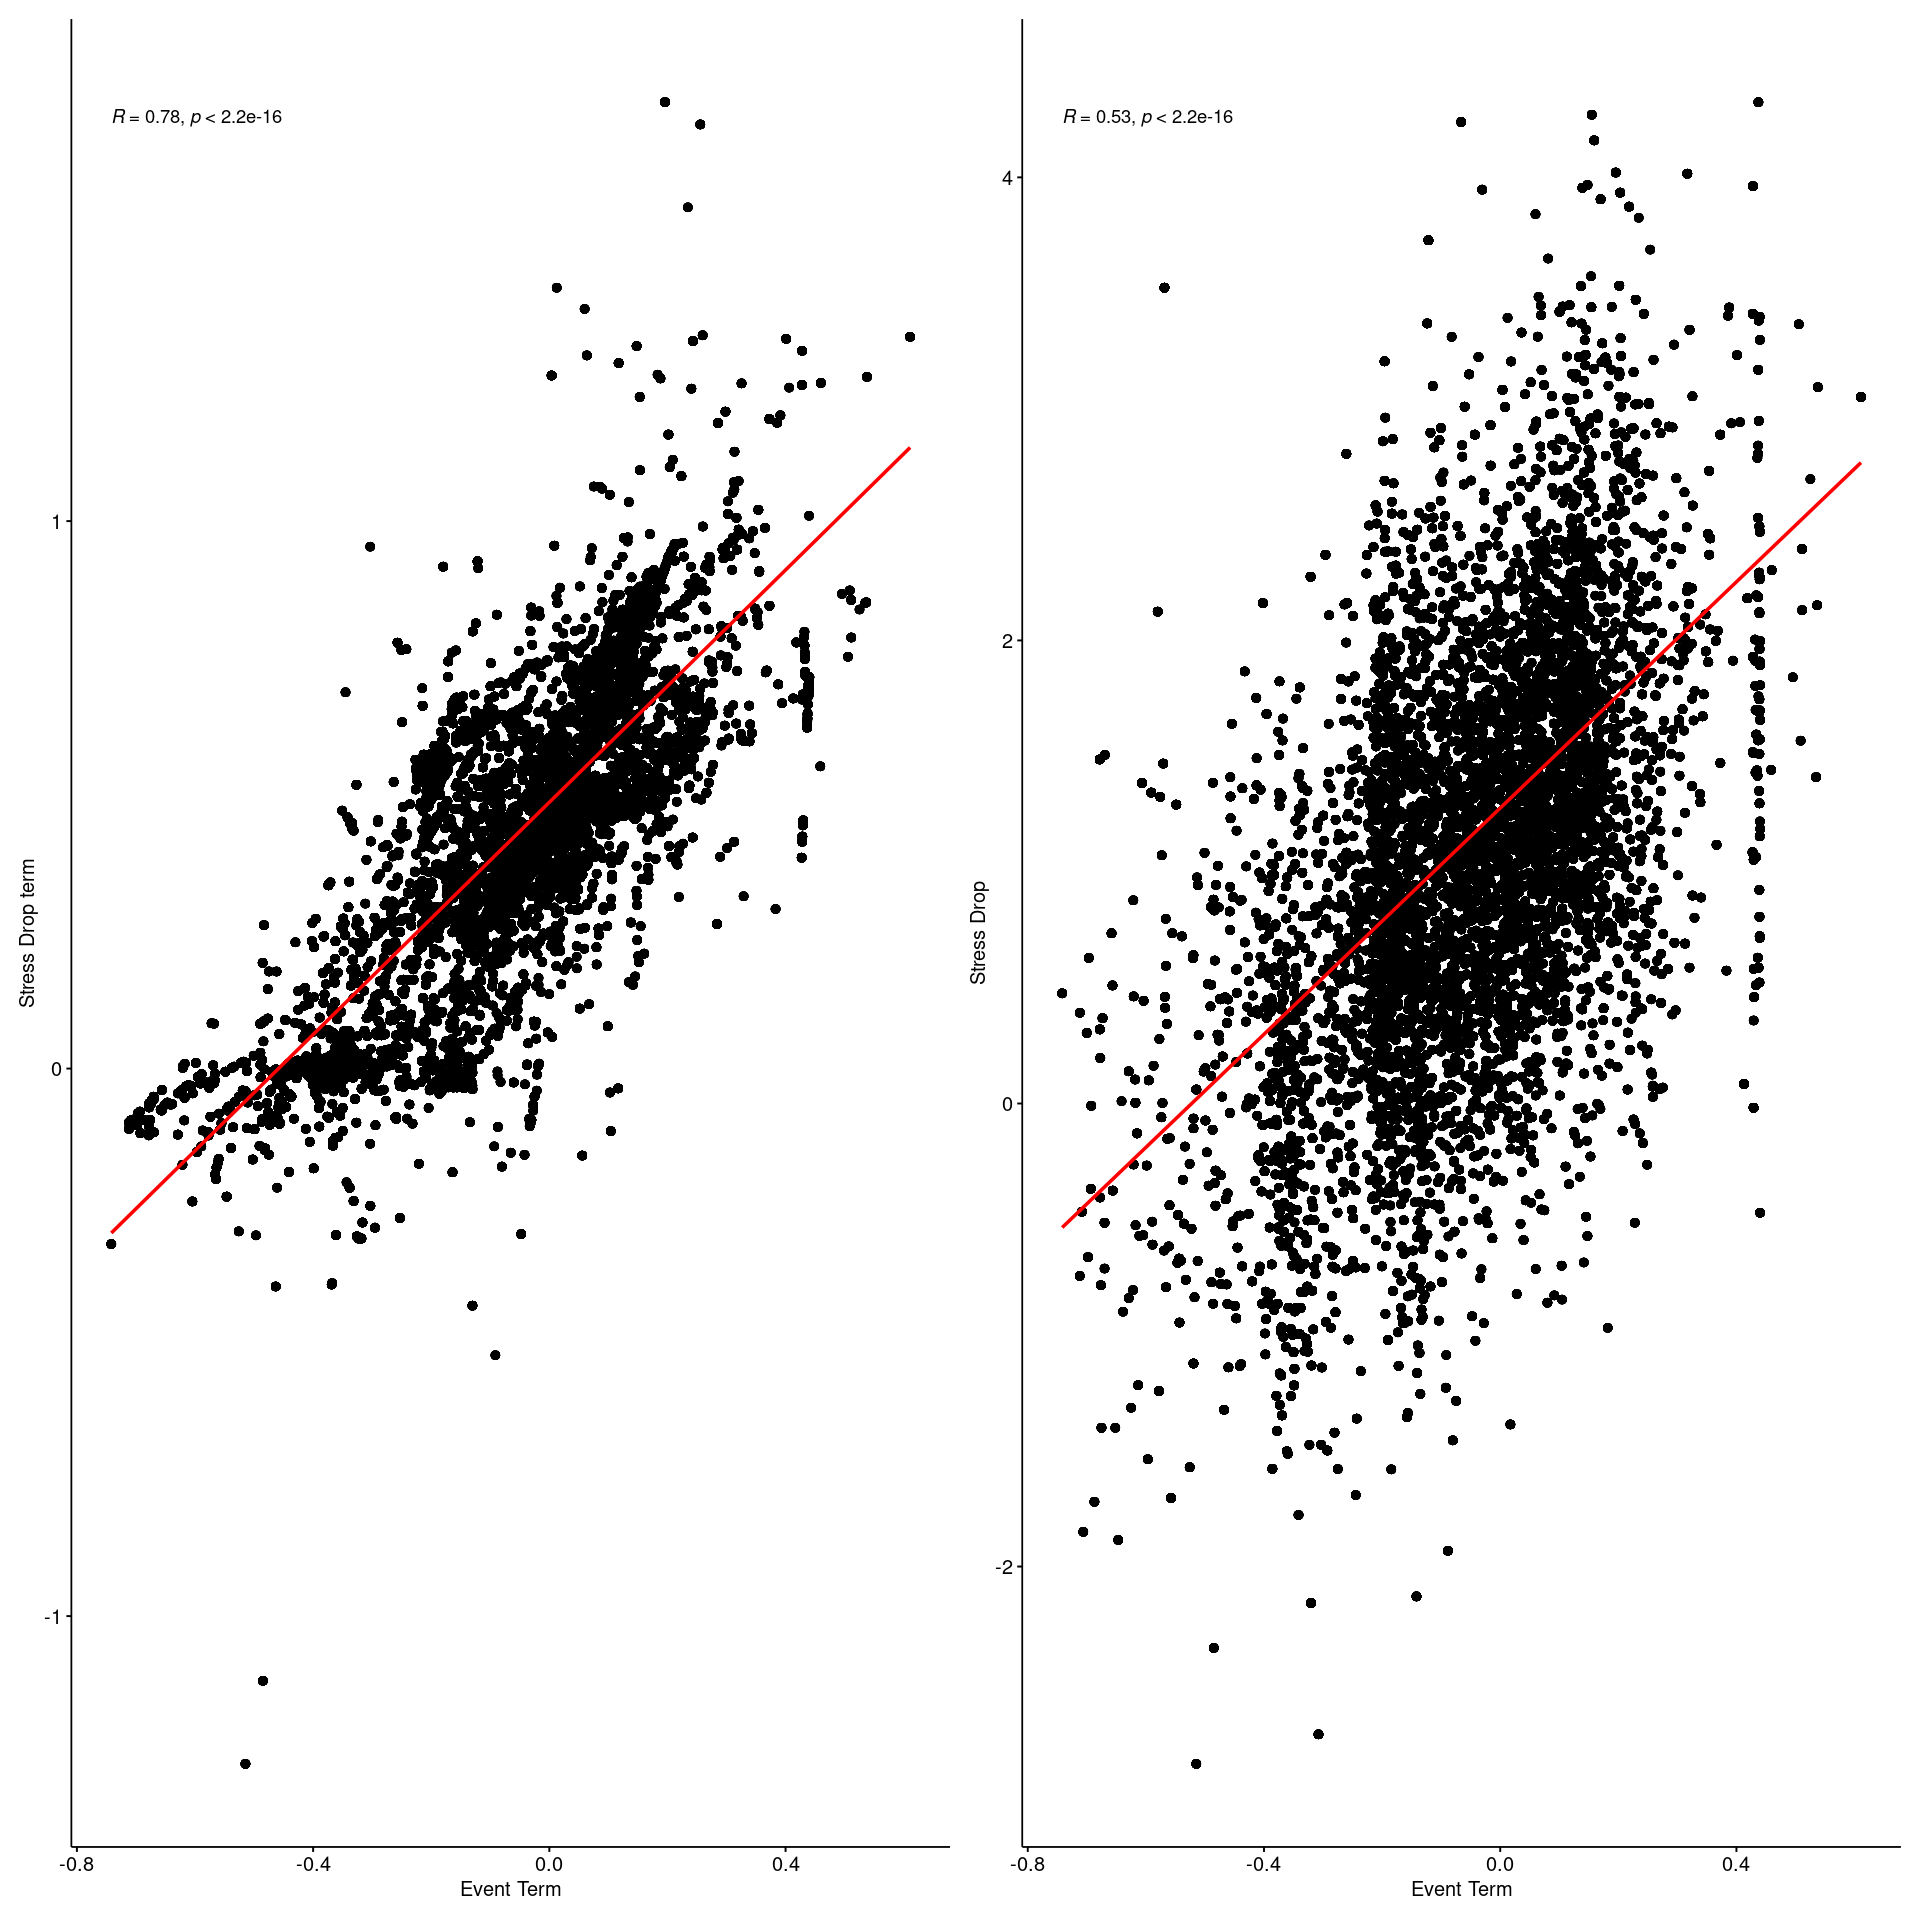

In [72]:
p3+p4